In [14]:
NOTEBOOK_NAME = "e019_use_yuki_baseline"

In [15]:
import os
import warnings
from pathlib import Path

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore")

In [16]:
ROOT_DIR = Path("../")
DATA_DIR = ROOT_DIR / Path("data")

In [17]:
train_df = pd.read_csv(DATA_DIR / Path("train.csv"))
test_df = pd.read_csv(DATA_DIR / Path("test.csv"))
era_df = pd.read_csv(DATA_DIR / Path("era.csv"))

display(train_df.head(5))
display(test_df.head(5))
display(era_df.head(5))

,名称,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度,is_kokuhou
0,泉布観,NaN,近代／文化施設,NaN,明治,大阪府,大阪府大阪市北区天満橋一丁目1番1号,NaN,大阪市,NaN,34.69811,135.5214,0
1,絹本著色准胝仏母像,NaN,絵画,日本,鎌倉,京都府（京都府）,NaN,NaN,広隆寺,NaN,NaN,NaN,0
2,石上神宮拝殿,NaN,近世以前／寺院,NaN,鎌倉前期,奈良県,奈良県天理市布留町,NaN,石上神宮,NaN,34.59780,135.8520,1
3,剣〈銘真守（備前）／〉,NaN,工芸品,日本,鎌倉,和歌山県（和歌山県）,NaN,NaN,宗教法人金剛峯寺,財団法人高野山文化財保存会,NaN,NaN,0
4,旧新町紡績所,工場本館,近代／産業・交通・土木,NaN,明治,群馬県,群馬県高崎市新町二三三〇番地,NaN,クラシエフーズ株式会社,NaN,36.27766,139.1003,0


,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度
0,NaN,工芸品,日本,江戸,京都府（京都府）,NaN,NaN,相国寺,NaN,NaN,NaN
1,NaN,絵画,日本,平安,和歌山県（和歌山県）,NaN,NaN,西禅院,財団法人高野山文化財保存会,NaN,NaN
2,NaN,絵画,日本,平安,東京都（東京都）,東京都世田谷区上野毛3-9-25,公益財団法人五島美術館,東急株式会社,NaN,35.612290,139.635500
3,NaN,近世以前／神社,NaN,江戸前期,和歌山県,和歌山県有田郡広川町大字上中野,NaN,廣八幡宮,NaN,34.017835,135.175324
4,NaN,彫刻,日本,平安,山形県（山形県）,NaN,NaN,吉祥院,NaN,NaN,NaN


,時代,開始,終了
0,鎌倉,1185,1333
1,元,1271,1368
2,古墳,250,538
3,江戸,1603,1868
4,高麗,918,1392


In [18]:
train_df = train_df.merge(era_df, how="left", on="時代")
test_df = test_df.merge(era_df, how="left", on="時代")

In [19]:
target = "is_kokuhou"
features = ["緯度", "経度", "開始", "終了", "国", "種別2", "管理団体又は責任者", "所有者名"]

In [20]:
categoricals = ["国", "種別2", "管理団体又は責任者", "所有者名"]
features = list(set(features) | set(categoricals))
for c in categoricals:
    le = LabelEncoder()
    le.fit(pd.concat([train_df, test_df])[c].astype(str))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))

In [21]:
params = {
    "n_estimators": 5000,
    "boosting_type": "gbdt",
    "metric": "auc",
    "objective": "binary",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.01,
}

oof_pred = np.zeros(len(train_df))
y_pred = np.zeros(len(test_df))
models = []
cv_scores = {}
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for fold, (train_index, test_index) in enumerate(
    skf.split(train_df[features], train_df[target])
):
    print(f"====== fold {fold} ======")

    # TrainとTestに分割
    x_train, x_val = (
        train_df.copy().iloc[train_index][features],
        train_df.copy().iloc[test_index][features],
    )
    y_train, y_val = (
        train_df.iloc[train_index][target],
        train_df.iloc[test_index][target],
    )

    test = test_df[features]

    # create Dataset
    train_set = lgb.Dataset(
        x_train, y_train, categorical_feature=categoricals, free_raw_data=False
    )
    val_set = lgb.Dataset(
        x_val, y_val, categorical_feature=categoricals, free_raw_data=False
    )

    # train
    model = lgb.train(
        params,
        train_set,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[train_set, val_set],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    models.append(model)

    fold_pred = model.predict(x_val)

    score = roc_auc_score(y_val, fold_pred)
    cv_scores[f"cv{fold}"] = score

    oof_pred[test_index] = fold_pred

    y_pred += model.predict(test) / 5

    print(f"cv score: {score}")

oof_score = roc_auc_score(train_df[target], oof_pred)
print(f"OOF score: {oof_score}")

====== fold 0 ======
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 401, number of negative: 4967
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1019
[LightGBM] [Info] Number of data points in the train set: 5368, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.074702 -> initscore=-2.516610
[LightGBM] [Info] Start training from score -2.516610
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	training's auc: 0.914943	valid_1's auc: 0.820076
cv score: 0.8200764895330113
====== fold 1 ======
[LightGBM] [Warning] Categorical features with more bi

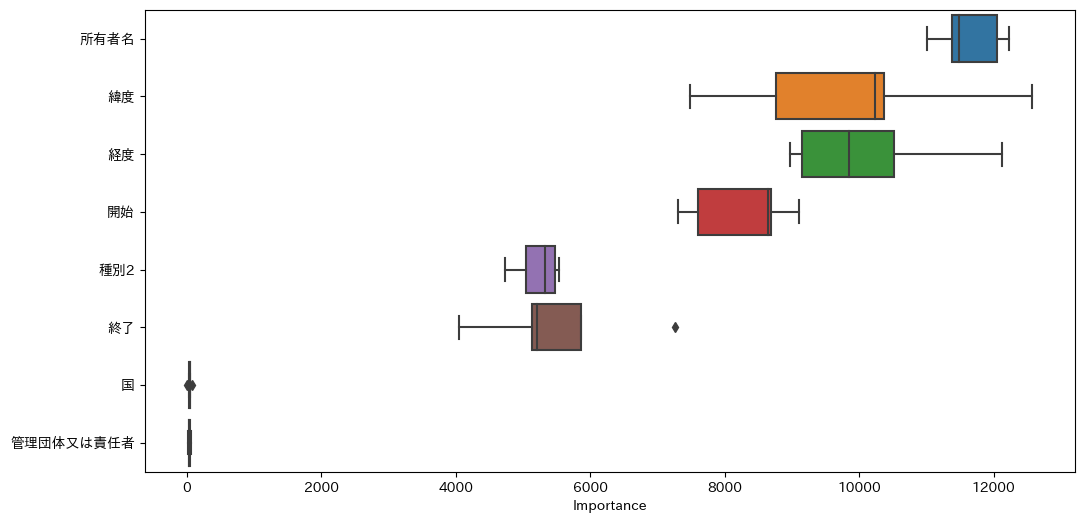

In [22]:
feature_importances = []

for model in models:
    feature_importances.append(model.feature_importance(importance_type="gain"))

feature_importances = np.array(feature_importances)
feature_importance_df = pd.DataFrame(feature_importances, columns=features)
sorted_features = feature_importance_df.median().sort_values(ascending=False).index
sorted_feature_importance_df = feature_importance_df[sorted_features]

plt.figure(figsize=(12, 6))
sns.boxplot(data=sorted_feature_importance_df, orient="h")
plt.xlabel("Importance")
plt.show()

In [23]:
from sklearn.metrics import f1_score

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(train_df["is_kokuhou"], (oof_pred > thr).astype(int))
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr

print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

thr: 0.01, f1_score: 0.16418659087109178
thr: 0.02, f1_score: 0.19701115554620083
thr: 0.03, f1_score: 0.2201321809862735
thr: 0.04, f1_score: 0.2489296636085627
thr: 0.05, f1_score: 0.26252983293556087
thr: 0.060000000000000005, f1_score: 0.28273809523809523
thr: 0.06999999999999999, f1_score: 0.2895485969906466
thr: 0.08, f1_score: 0.29819819819819815
thr: 0.09, f1_score: 0.30210325047801145
thr: 0.09999999999999999, f1_score: 0.3026052104208417
thr: 0.11, f1_score: 0.3020277481323373
thr: 0.12, f1_score: 0.301994301994302
thr: 0.13, f1_score: 0.3065781532890766
thr: 0.14, f1_score: 0.3067961165048544
thr: 0.15000000000000002, f1_score: 0.3018080667593881
thr: 0.16, f1_score: 0.3055350553505535
thr: 0.17, f1_score: 0.30434782608695654
thr: 0.18000000000000002, f1_score: 0.2987755102040816
thr: 0.19, f1_score: 0.303972366148532
thr: 0.2, f1_score: 0.30171635049683826
thr: 0.21000000000000002, f1_score: 0.3018867924528302
thr: 0.22, f1_score: 0.30126336248785224
thr: 0.23, f1_score: 0.

In [24]:
test_df["is_kokuhou"] = (y_pred > best_thr).astype(int)

In [25]:
test_df[["is_kokuhou"]].to_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv",
    index=False,
)